In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import display, Audio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

### Load style and content

In [2]:
CONTENT_FILENAME = "inputs/bach_violin.wav"
STYLE_FILENAME = "inputs/saxophone.m4a"

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

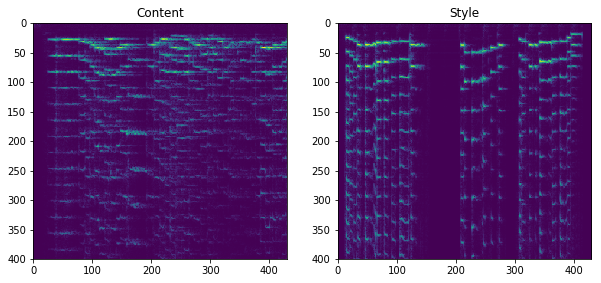

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [16]:

N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])
## filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
kernel2 = np.random.randn(1,11, N_FILTERS, N_FILTERS)*std


g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")
    print("X shape:", x.get_shape()) # SHAPE: (1, 1, 430, 1025)
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    kernel_tf2 = tf.constant(kernel2, name="kernel2", dtype='float32')
    conv1 = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv1")         # SHAPE: (1, 1, 420, 4096)      
    print("Post CNN 1 shape: ", conv1.get_shape())
    
    net1 = tf.nn.relu(conv1)
    
    ## Testing 2 conv layers
    conv2 = tf.nn.conv2d(
        net1,
        kernel_tf2,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv2")
#     print("Post CNN 2 shape: ", conv2.get_shape())

    net2 = tf.nn.relu(conv2)
        
#     content_features1, content_features2 = sess.run([net1, net2], feed_dict={x: a_content_tf})
#     style_features1, style_features2 = sess.run([net1, net2], feed_dict={x: a_style_tf})

    content_features1 = net1.eval(feed_dict={x: a_content_tf})
#     style_features1 = net1.eval(feed_dict={x: a_style_tf})
    
    style_features1 = np.reshape(style_features1, (-1, N_FILTERS))
    style_gram1 = np.matmul(style_features1.T, style_features1) / N_SAMPLES
    
    
#     content_features2 = net2.eval(feed_dict={x: content_features1})
#     style_features2 = net2.eval(feed_dict={x: style_features1})
    style_features2 = np.reshape(style_features2, (-1, N_FILTERS))
    style_gram2 = np.matmul(style_features2.T, style_features2) / N_SAMPLES
    
    
    
    print "DONE WITH THIS SECTION!"

('X shape:', TensorShape([Dimension(1), Dimension(1), Dimension(430), Dimension(1025)]))
('Post CNN 1 shape: ', TensorShape([Dimension(1), Dimension(1), Dimension(420), Dimension(4096)]))
DONE WITH THIS SECTION!


### Optimize

In [29]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default(), tf.Session() as sess:
    # Build graph with variable input
    x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    kernel_tf2 = tf.constant(kernel2, name="kernel2", dtype='float32')
    conv1 = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv1")         # SHAPE: (1, 1, 420, 4096)      
    print("Post CNN 1 shape: ", conv1.get_shape())
    
    ## Testing 2 conv layers
    conv2 = tf.nn.conv2d(
        conv1,
        kernel_tf2,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv2")
    net1 = tf.nn.relu(conv1)
    net2 = tf.nn.relu(conv2)
    print net1.get_shape(), conv1.get_shape()
    print net2.get_shape(), conv2.get_shape()
    output_features1, output_features2 = sess.run([net1, net2], feed_dict={x: a_content_tf})    
    
#     content_loss = ALPHA * 2 * tf.nn.l2_loss(
#            output_features2 - content_features2)
    
    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net2.get_shape())

    # gram matrix from layer 1
    size = height * width * number
    feats1 = tf.reshape(output_features1, (-1, number))
    gram1 = tf.matmul(tf.transpose(feats1), feats1)  / N_SAMPLES
    
    _, height, width, number = map(lambda i: i.value, net2.get_shape())
    
    # gram matrix from layer 2
    size = height * width * number
    feats2 = tf.reshape(output_features2, (-1, number))
    gram2 = tf.matmul(tf.transpose(feats2), feats2)  / N_SAMPLES
    
    #loss_term = (gram1 - style_gram1) + (gram2 - style_gram2)
    loss_term = (gram2 - style_gram2)
    style_loss = 2 * tf.nn.l2_loss(loss_term)

     # Overall loss
    loss = style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
    
    print 'GOT TO OPT STEP'
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

('Post CNN 1 shape: ', TensorShape([Dimension(1), Dimension(1), Dimension(420), Dimension(4096)]))
(1, 1, 420, 4096) (1, 1, 420, 4096)
(1, 1, 410, 4096) (1, 1, 410, 4096)
GOT TO OPT STEP
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 63971.363281
  Number of iterations: 0
  Number of functions evaluations: 1
Final loss: 63971.4


In [28]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/violin_content_sax_style.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [40]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

outputs/cello_content_sax_style.wav


### Visualize spectrograms

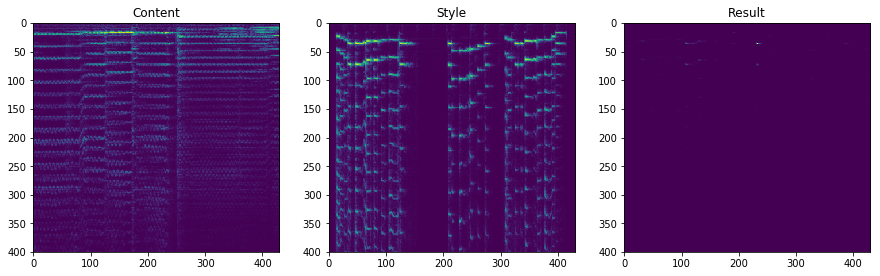

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()